In [13]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from numpy import asarray
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops


In [7]:
# Get labels
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [9]:
# Get model 
hub_model = hub.load("https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1")

2022-07-12 17:50:44.990742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [111]:
# Get image 
import glob
image_list = []
for filename in glob.glob('./carter_images/dog/*.jpg'): #assuming gif
    image_list.append([np.array(asarray(Image.open(filename).resize((3000,4000)))),])
image_list = np.vstack(image_list)

flip_image_horizontally = False
convert_image_to_grayscale = False

image_path = "./carter_images/dog/IMG_1924.jpg"
image_np = np.array([asarray(Image.open(image_path)),])
print(image_np.shape)
print(image_list.shape)
# Flip horizontally
if(flip_image_horizontally):
    image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
    image_np[0] = np.tile(
       np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
'''
plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()
'''

(1, 4032, 3024, 3)
(5, 4000, 3000, 3)


'\nplt.figure(figsize=(24,32))\nplt.imshow(image_np[0])\nplt.show()\n'

In [122]:
# Inference 
#results = hub_model(image_np)
results = hub_model(image_list[3:4])

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['detection_keypoints', 'detection_scores', 'detection_keypoint_scores', 'detection_boxes', 'detection_classes', 'num_detections'])


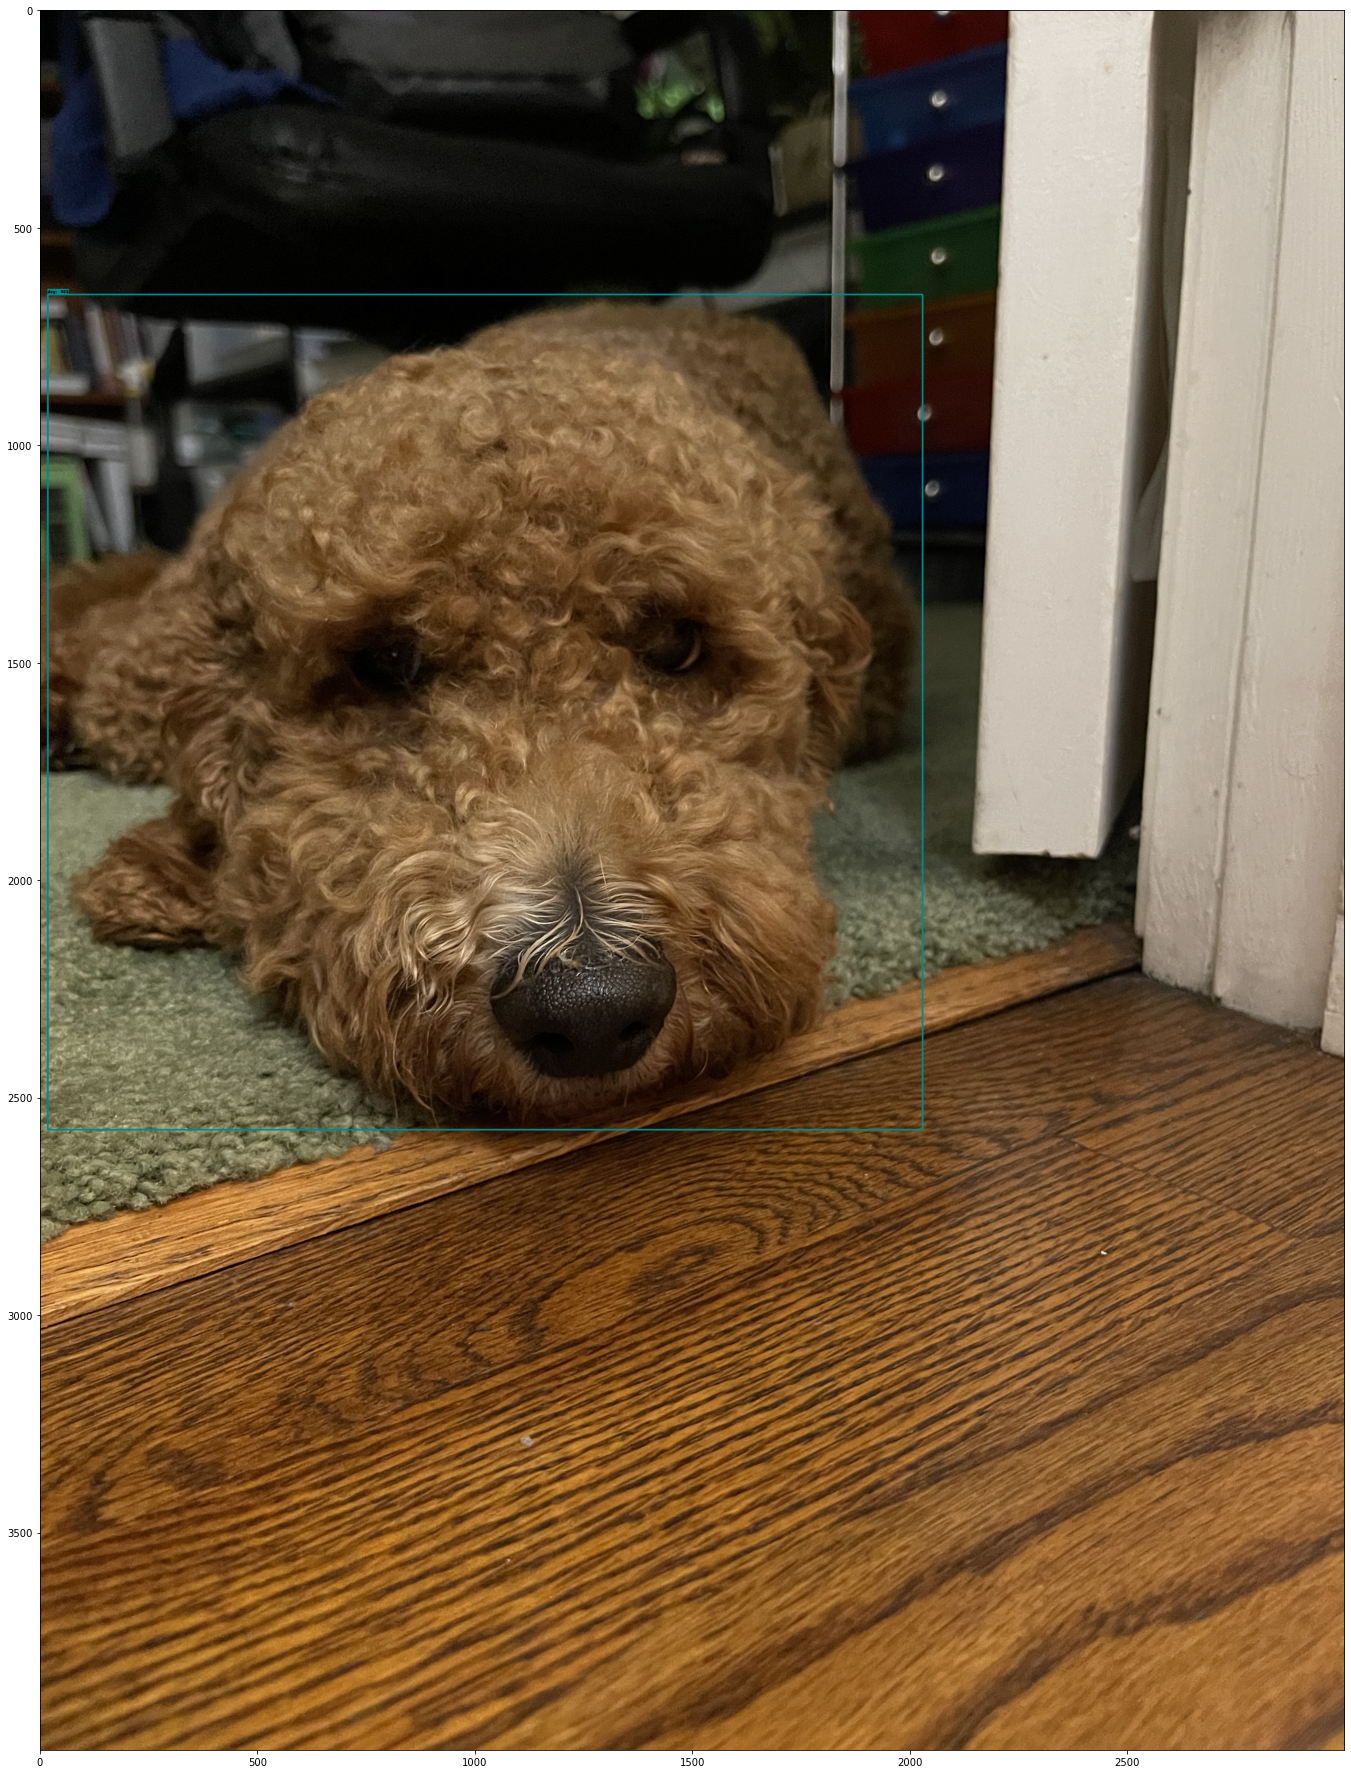

{'id': 18, 'name': 'dog'}
0.85798186


In [124]:
# Visualizing results 
label_id_offset = 0
#image_np_with_detections = image_np.copy()
image_np_with_detections = image_list[3:4].copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
    keypoints = result['detection_keypoints'][0]
    keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.60,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores)
#      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

for i in range(len(result['detection_scores'][0])): 
    if(result['detection_scores'][0][i] > .6):
        print(category_index[int(result['detection_classes'][0][i])])
        print(result['detection_scores'][0][i])